<div style="margin-bottom: 32px;">
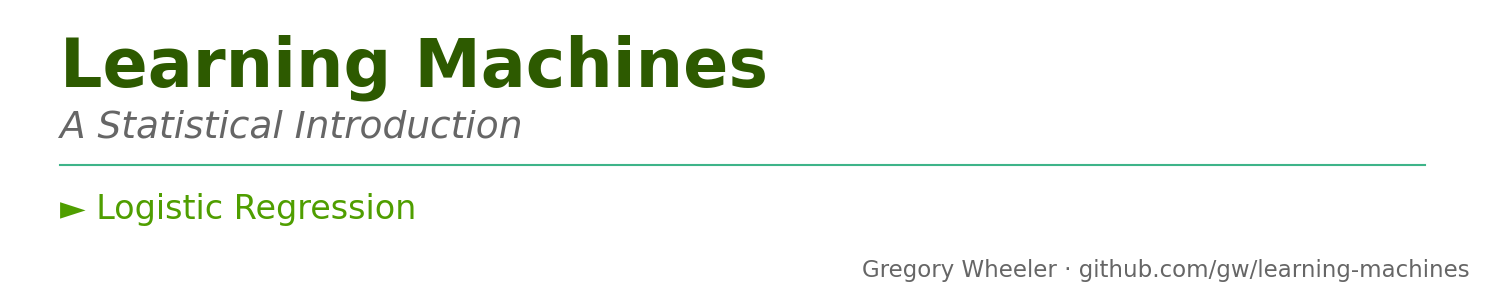
</div>


# Logistic Regression

Binary classification requires a different approach than regression. This notebook makes logistic regression concrete: we see why linear regression fails for classification, how the sigmoid function produces probabilities, and how gradient descent finds the decision boundary.

**What computation adds**: The textbook derives the gradient analytically. Here we watch the algorithm converge, visualize decision boundaries in 1D and 2D, and explore how the classification threshold affects the precision-recall tradeoff.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
from pathlib import Path

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

# For reproducibility
np.random.seed(42)

---
## 1. The Classification Problem

In classification, our target variable $y$ takes discrete values. For **binary classification**, we have $y \in \{0, 1\}$.

Let's generate a simple dataset where we want to predict whether a student passes an exam based on hours studied.

In [2]:
# Generate synthetic data: hours studied vs pass/fail
np.random.seed(42)
n_samples = 40

# Students who failed (y=0): studied fewer hours
hours_fail = np.random.normal(3, 1.2, n_samples // 2)
hours_fail = np.clip(hours_fail, 0.5, 6)

# Students who passed (y=1): studied more hours
hours_pass = np.random.normal(7, 1.2, n_samples // 2)
hours_pass = np.clip(hours_pass, 4, 10)

# Combine
hours = np.concatenate([hours_fail, hours_pass])
passed = np.concatenate([np.zeros(n_samples // 2), np.ones(n_samples // 2)])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
hours = hours[shuffle_idx]
passed = passed[shuffle_idx]

print(f"Dataset: {n_samples} students")
print(f"Hours studied: min={hours.min():.1f}, max={hours.max():.1f}")
print(f"Pass rate: {passed.mean():.1%}")

Dataset: 40 students
Hours studied: min=0.7, max=9.2
Pass rate: 50.0%


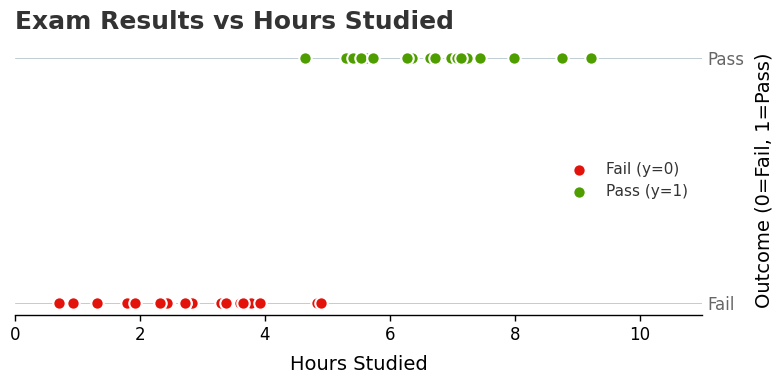

In [3]:
# Visualize the data
fig, ax = plt.subplots(figsize=(8, 4))

# Plot pass/fail with different colors
mask_pass = passed == 1
ax.scatter(hours[~mask_pass], passed[~mask_pass], c=mt.RED, s=80, 
           label='Fail (y=0)', edgecolors='white', linewidths=1.5, zorder=3)
ax.scatter(hours[mask_pass], passed[mask_pass], c=mt.GREEN, s=80,
           label='Pass (y=1)', edgecolors='white', linewidths=1.5, zorder=3)

ax.set_xlabel('Hours Studied')
ax.set_ylabel('Outcome (0=Fail, 1=Pass)')
ax.set_title('Exam Results vs Hours Studied', fontweight='bold', loc='left')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Fail', 'Pass'])
ax.legend(loc='center right')
ax.set_xlim(0, 11)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

---
## 2. Why Linear Regression Fails

What if we tried to fit a linear regression model $h(x) = \theta_0 + \theta_1 x$ to this classification problem?

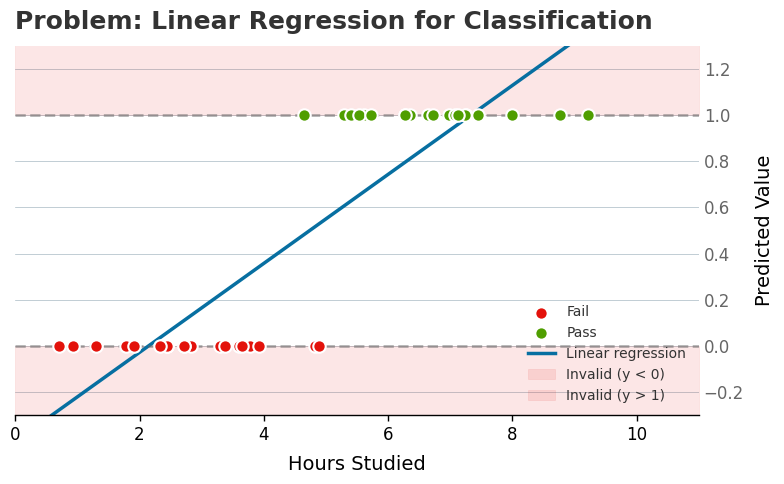

Linear model: h(x) = -0.412 + 0.192x

Problems:
  - Prediction at x=0: -0.41 (should be in [0,1])
  - Prediction at x=10: 1.51 (should be in [0,1])


In [4]:
# Fit linear regression to classification data
X_design = np.column_stack([np.ones(n_samples), hours])
theta_linear = np.linalg.lstsq(X_design, passed, rcond=None)[0]

# Generate predictions
x_plot = np.linspace(0, 11, 100)
y_linear = theta_linear[0] + theta_linear[1] * x_plot

fig, ax = plt.subplots(figsize=(8, 5))

# Data points
ax.scatter(hours[~mask_pass], passed[~mask_pass], c=mt.RED, s=80,
           label='Fail', edgecolors='white', linewidths=1.5, zorder=3)
ax.scatter(hours[mask_pass], passed[mask_pass], c=mt.GREEN, s=80,
           label='Pass', edgecolors='white', linewidths=1.5, zorder=3)

# Linear regression line
ax.plot(x_plot, y_linear, c=mt.BLUE, linewidth=2.5, label='Linear regression')

# Show problems
ax.axhline(y=0, color=mt.GRAY, linestyle='--', alpha=0.5)
ax.axhline(y=1, color=mt.GRAY, linestyle='--', alpha=0.5)

# Shade invalid regions
ax.fill_between(x_plot, -0.5, 0, alpha=0.1, color=mt.RED, label='Invalid (y < 0)')
ax.fill_between(x_plot, 1, 1.5, alpha=0.1, color=mt.RED, label='Invalid (y > 1)')

ax.set_xlabel('Hours Studied')
ax.set_ylabel('Predicted Value')
ax.set_title('Problem: Linear Regression for Classification', fontweight='bold', loc='left')
ax.set_xlim(0, 11)
ax.set_ylim(-0.3, 1.3)
ax.legend(loc='lower right', fontsize=10)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

print(f"Linear model: h(x) = {theta_linear[0]:.3f} + {theta_linear[1]:.3f}x")
print(f"\nProblems:")
print(f"  - Prediction at x=0: {theta_linear[0]:.2f} (should be in [0,1])")
print(f"  - Prediction at x=10: {theta_linear[0] + theta_linear[1]*10:.2f} (should be in [0,1])")

**Problems with linear regression for classification:**
1. Predictions can be **less than 0** or **greater than 1**
2. We want **probabilities**, not arbitrary values
3. The relationship between features and class probability is often **nonlinear**

---
## 3. The Sigmoid Function

The **sigmoid function** (also called the logistic function) maps any real number to the interval $(0, 1)$:

$$g(z) = \frac{1}{1 + e^{-z}}$$

This makes it perfect for modeling probabilities.

In [5]:
def sigmoid(z):
    """The sigmoid (logistic) function."""
    return 1 / (1 + np.exp(-z))

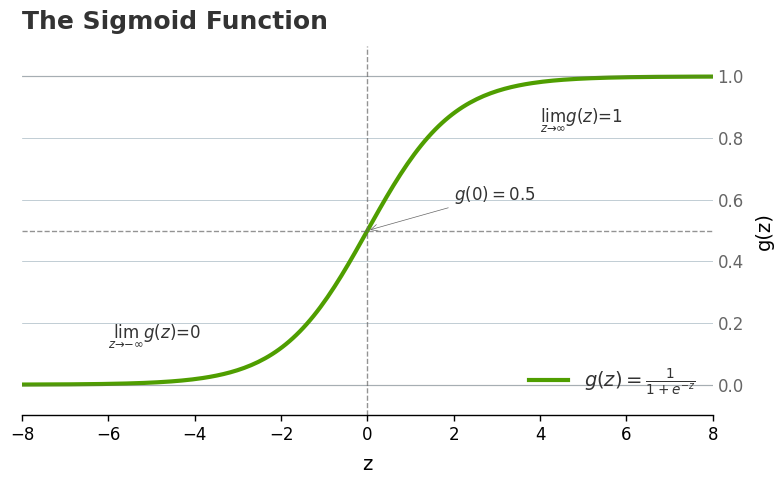

In [6]:
# Visualize the sigmoid function
z = np.linspace(-8, 8, 200)
g_z = sigmoid(z)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(z, g_z, c=mt.GREEN, linewidth=3, label=r'$g(z) = \frac{1}{1 + e^{-z}}$')

# Reference lines
ax.axhline(y=0.5, color=mt.GRAY, linestyle='--', alpha=0.7, linewidth=1)
ax.axhline(y=0, color=mt.GRAY, linestyle='-', alpha=0.3, linewidth=1)
ax.axhline(y=1, color=mt.GRAY, linestyle='-', alpha=0.3, linewidth=1)
ax.axvline(x=0, color=mt.GRAY, linestyle='--', alpha=0.7, linewidth=1)

# Annotations
ax.annotate(r'$g(0) = 0.5$', xy=(0, 0.5), xytext=(2, 0.6),
            fontsize=12, arrowprops=dict(arrowstyle='->', color=mt.GRAY))
ax.annotate(r'$\lim_{z \to \infty} g(z) = 1$', xy=(6, 0.998), xytext=(4, 0.85),
            fontsize=12)
ax.annotate(r'$\lim_{z \to -\infty} g(z) = 0$', xy=(-6, 0.002), xytext=(-6, 0.15),
            fontsize=12)

ax.set_xlabel('z')
ax.set_ylabel('g(z)')
ax.set_title('The Sigmoid Function', fontweight='bold', loc='left')
ax.set_xlim(-8, 8)
ax.set_ylim(-0.1, 1.1)
ax.legend(loc='lower right', fontsize=14)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

**Key properties of the sigmoid:**
- Output always in $(0, 1)$ — interpretable as probability
- $g(0) = 0.5$ — the decision boundary when $z = 0$
- Symmetric: $g(-z) = 1 - g(z)$
- Smooth and differentiable everywhere

---
## 4. The Logistic Regression Hypothesis

In logistic regression, we model the **probability** that $y = 1$ given input $x$:

$$h(x; \boldsymbol{\theta}) = g(\boldsymbol{\theta}^T x) = \frac{1}{1 + e^{-\boldsymbol{\theta}^T x}}$$

where $\boldsymbol{\theta}^T x = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots$

This gives us:
- $P(y = 1 \mid x; \theta) = h(x; \theta)$
- $P(y = 0 \mid x; \theta) = 1 - h(x; \theta)$

In [7]:
def hypothesis(X, theta):
    """Logistic regression hypothesis: h(x) = sigmoid(X @ theta)"""
    return sigmoid(X @ theta)

---
## 5. The Cost Function: Log-Loss

We cannot use MSE for logistic regression — it creates a non-convex optimization problem. Instead, we use the **log-loss** (cross-entropy) cost function:

$$J(\boldsymbol{\theta}) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h(x^{(i)})) + (1 - y^{(i)}) \log(1 - h(x^{(i)})) \right]$$

**Intuition:**
- When $y = 1$: we want $h(x) \to 1$, so we penalize $-\log(h(x))$
- When $y = 0$: we want $h(x) \to 0$, so we penalize $-\log(1 - h(x))$

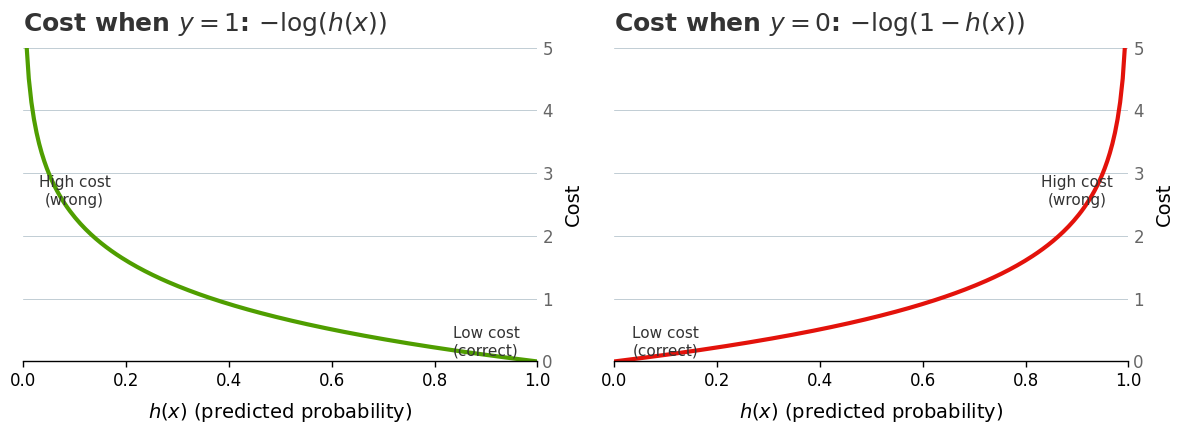

In [8]:
# Visualize the cost for a single example
h = np.linspace(0.001, 0.999, 200)

cost_y1 = -np.log(h)      # Cost when y = 1
cost_y0 = -np.log(1 - h)  # Cost when y = 0

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# When y = 1
ax = axes[0]
ax.plot(h, cost_y1, c=mt.GREEN, linewidth=3)
ax.set_xlabel(r'$h(x)$ (predicted probability)')
ax.set_ylabel('Cost')
ax.set_title(r'Cost when $y = 1$: $-\log(h(x))$', fontweight='bold', loc='left')
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)
ax.annotate('Low cost\n(correct)', xy=(0.9, 0.1), fontsize=11, ha='center')
ax.annotate('High cost\n(wrong)', xy=(0.1, 2.5), fontsize=11, ha='center')
mt.apply_economist_style(ax)

# When y = 0
ax = axes[1]
ax.plot(h, cost_y0, c=mt.RED, linewidth=3)
ax.set_xlabel(r'$h(x)$ (predicted probability)')
ax.set_ylabel('Cost')
ax.set_title(r'Cost when $y = 0$: $-\log(1 - h(x))$', fontweight='bold', loc='left')
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)
ax.annotate('Low cost\n(correct)', xy=(0.1, 0.1), fontsize=11, ha='center')
ax.annotate('High cost\n(wrong)', xy=(0.9, 2.5), fontsize=11, ha='center')
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

In [9]:
def compute_cost(X, y, theta):
    """
    Compute the log-loss cost function for logistic regression.
    
    Parameters
    ----------
    X : ndarray of shape (m, n)
        Feature matrix with intercept column
    y : ndarray of shape (m,)
        Binary labels (0 or 1)
    theta : ndarray of shape (n,)
        Model parameters
    
    Returns
    -------
    float
        The log-loss cost
    """
    m = len(y)
    h = hypothesis(X, theta)
    
    # Clip to avoid log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    
    cost = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

---
## 6. The Gradient

The gradient of the log-loss with respect to $\boldsymbol{\theta}$ has a remarkably elegant form:

$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h(x^{(i)}) - y^{(i)}) x_j^{(i)}$$

In matrix form:
$$\nabla J(\boldsymbol{\theta}) = \frac{1}{m} X^T (h(X; \boldsymbol{\theta}) - y)$$

Note: This looks identical to the gradient for linear regression, but remember that $h(x)$ is now the sigmoid, not a linear function.

In [10]:
def compute_gradient(X, y, theta):
    """
    Compute the gradient of the log-loss cost function.
    
    Parameters
    ----------
    X : ndarray of shape (m, n)
        Feature matrix with intercept column
    y : ndarray of shape (m,)
        Binary labels
    theta : ndarray of shape (n,)
        Model parameters
    
    Returns
    -------
    ndarray of shape (n,)
        Gradient vector
    """
    m = len(y)
    h = hypothesis(X, theta)
    gradient = (1/m) * X.T @ (h - y)
    return gradient

---
## 7. Gradient Descent for Logistic Regression

We use the same gradient descent algorithm as before:

$$\boldsymbol{\theta} := \boldsymbol{\theta} - \alpha \nabla J(\boldsymbol{\theta})$$

In [11]:
def gradient_descent(X, y, theta_init, learning_rate, n_iterations):
    """
    Perform gradient descent for logistic regression.
    
    Returns
    -------
    theta : final parameters
    cost_history : cost at each iteration
    theta_history : parameters at each iteration
    """
    theta = theta_init.copy()
    cost_history = []
    theta_history = [theta.copy()]
    
    for i in range(n_iterations):
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
        
        gradient = compute_gradient(X, y, theta)
        theta = theta - learning_rate * gradient
        theta_history.append(theta.copy())
    
    return theta, np.array(cost_history), np.array(theta_history)

In [12]:
# Prepare data with intercept
X = np.column_stack([np.ones(n_samples), hours])
y = passed

# Initialize parameters
theta_init = np.zeros(2)

# Run gradient descent
learning_rate = 0.5
n_iterations = 200

theta_final, cost_history, theta_history = gradient_descent(
    X, y, theta_init, learning_rate, n_iterations
)

print(f"Initial cost: {cost_history[0]:.4f}")
print(f"Final cost: {cost_history[-1]:.4f}")
print(f"\nLearned parameters:")
print(f"  theta_0 (intercept): {theta_final[0]:.4f}")
print(f"  theta_1 (hours): {theta_final[1]:.4f}")

Initial cost: 0.6931
Final cost: 0.1679

Learned parameters:
  theta_0 (intercept): -5.7598
  theta_1 (hours): 1.2675


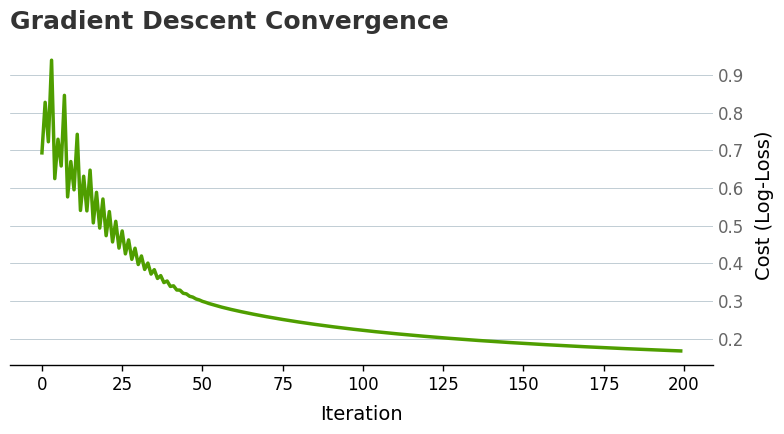

In [13]:
# Visualize convergence
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(cost_history, c=mt.GREEN, linewidth=2.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost (Log-Loss)')
ax.set_title('Gradient Descent Convergence', fontweight='bold', loc='left')

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

---
## 8. Decision Boundary

The **decision boundary** is where $h(x) = 0.5$, which occurs when:

$$\boldsymbol{\theta}^T x = 0$$

For our single-feature case: $\theta_0 + \theta_1 x = 0$, so the boundary is at:

$$x = -\frac{\theta_0}{\theta_1}$$

In [14]:
# Calculate decision boundary
decision_boundary = -theta_final[0] / theta_final[1]
print(f"Decision boundary: {decision_boundary:.2f} hours")
print(f"Students who study more than {decision_boundary:.1f} hours are predicted to pass.")

Decision boundary: 4.54 hours
Students who study more than 4.5 hours are predicted to pass.


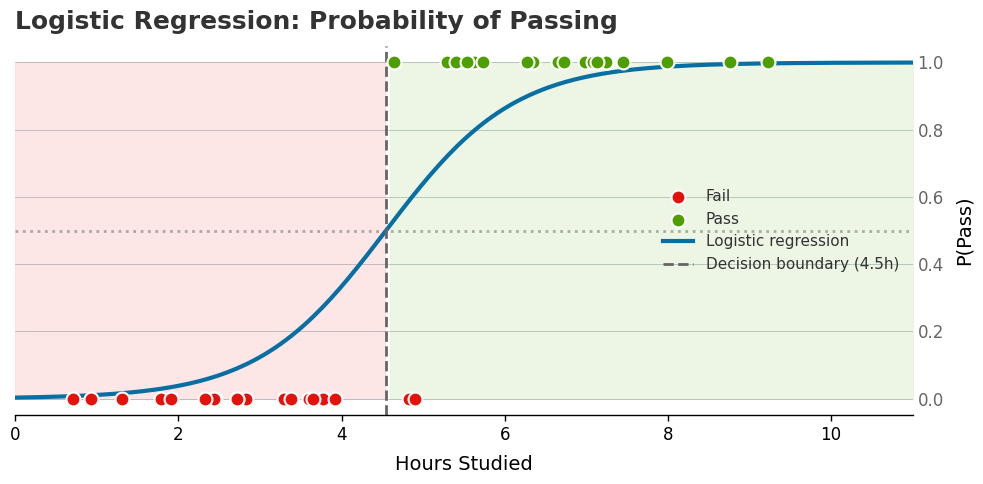

In [15]:
# Visualize the logistic regression fit
fig, ax = plt.subplots(figsize=(10, 5))

# Data points
ax.scatter(hours[~mask_pass], passed[~mask_pass], c=mt.RED, s=100,
           label='Fail', edgecolors='white', linewidths=1.5, zorder=3)
ax.scatter(hours[mask_pass], passed[mask_pass], c=mt.GREEN, s=100,
           label='Pass', edgecolors='white', linewidths=1.5, zorder=3)

# Sigmoid curve
x_plot = np.linspace(0, 11, 200)
X_plot = np.column_stack([np.ones(len(x_plot)), x_plot])
prob_plot = hypothesis(X_plot, theta_final)
ax.plot(x_plot, prob_plot, c=mt.BLUE, linewidth=3, label='Logistic regression')

# Decision boundary
ax.axvline(x=decision_boundary, color=mt.GRAY, linestyle='--', linewidth=2,
           label=f'Decision boundary ({decision_boundary:.1f}h)')
ax.axhline(y=0.5, color=mt.GRAY, linestyle=':', alpha=0.5)

# Shade prediction regions
ax.fill_between(x_plot, 0, 1, where=x_plot < decision_boundary,
                alpha=0.1, color=mt.RED)
ax.fill_between(x_plot, 0, 1, where=x_plot >= decision_boundary,
                alpha=0.1, color=mt.GREEN)

ax.set_xlabel('Hours Studied')
ax.set_ylabel('P(Pass)')
ax.set_title('Logistic Regression: Probability of Passing', fontweight='bold', loc='left')
ax.set_xlim(0, 11)
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='center right')

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

---
## 9. Two-Feature Classification

Let's explore a more interesting case with two features, where the decision boundary is a line in 2D.

In [16]:
# Generate 2D classification data
np.random.seed(123)
n_samples_2d = 100

# Class 0: centered at (2, 2)
X0 = np.random.randn(n_samples_2d // 2, 2) * 0.8 + np.array([2, 2])

# Class 1: centered at (4, 4)
X1 = np.random.randn(n_samples_2d // 2, 2) * 0.8 + np.array([4, 4])

# Combine
X_2d = np.vstack([X0, X1])
y_2d = np.array([0] * (n_samples_2d // 2) + [1] * (n_samples_2d // 2))

# Add intercept
X_2d_design = np.column_stack([np.ones(n_samples_2d), X_2d])

In [17]:
# Fit logistic regression
theta_init_2d = np.zeros(3)
theta_2d, cost_history_2d, _ = gradient_descent(
    X_2d_design, y_2d, theta_init_2d, learning_rate=0.5, n_iterations=500
)

print(f"Learned parameters:")
print(f"  theta_0: {theta_2d[0]:.4f}")
print(f"  theta_1: {theta_2d[1]:.4f}")
print(f"  theta_2: {theta_2d[2]:.4f}")

Learned parameters:
  theta_0: -8.2511
  theta_1: 1.6258
  theta_2: 1.0762


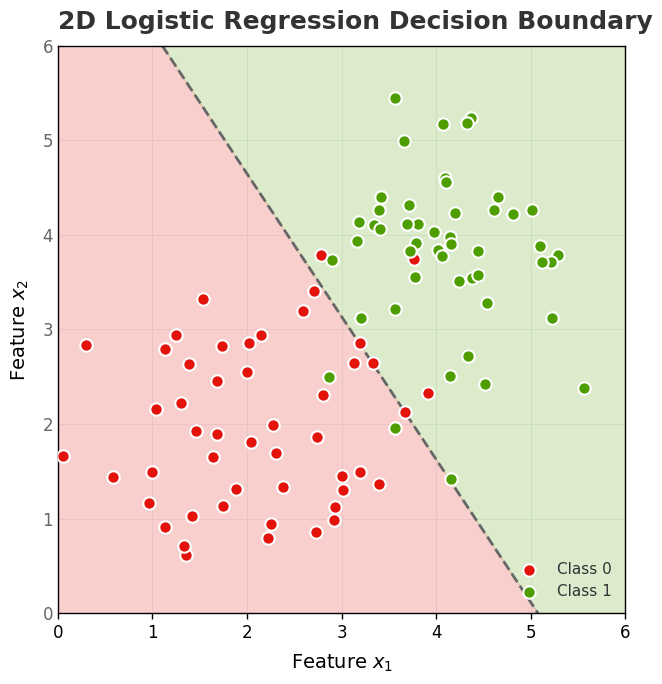

In [18]:
# Visualize 2D decision boundary
fig, ax = plt.subplots(figsize=(8, 7))

# Create mesh for decision regions
xx, yy = np.meshgrid(np.linspace(0, 6, 200), np.linspace(0, 6, 200))
X_mesh = np.column_stack([np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()])
Z = hypothesis(X_mesh, theta_2d).reshape(xx.shape)

# Decision regions
ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=[mt.RED, mt.GREEN], alpha=0.2)
ax.contour(xx, yy, Z, levels=[0.5], colors=[mt.GRAY], linewidths=2, linestyles='--')

# Data points
ax.scatter(X0[:, 0], X0[:, 1], c=mt.RED, s=80, label='Class 0',
           edgecolors='white', linewidths=1.5, zorder=3)
ax.scatter(X1[:, 0], X1[:, 1], c=mt.GREEN, s=80, label='Class 1',
           edgecolors='white', linewidths=1.5, zorder=3)

ax.set_xlabel('Feature $x_1$')
ax.set_ylabel('Feature $x_2$')
ax.set_title('2D Logistic Regression Decision Boundary', fontweight='bold', loc='left')
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
ax.legend(loc='lower right')

# Custom styling for 2D plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 10. Making Predictions

To make predictions, we:
1. Compute $h(x) = \sigma(\boldsymbol{\theta}^T x)$ to get probabilities
2. Apply a threshold (typically 0.5) to get class labels

In [19]:
def predict(X, theta, threshold=0.5):
    """Make binary predictions using logistic regression."""
    probabilities = hypothesis(X, theta)
    return (probabilities >= threshold).astype(int)

def accuracy(y_true, y_pred):
    """Calculate classification accuracy."""
    return np.mean(y_true == y_pred)

In [20]:
# Evaluate on training data (1D example)
y_pred = predict(X, theta_final)
train_accuracy = accuracy(y, y_pred)

print(f"Training accuracy: {train_accuracy:.1%}")
print(f"\nConfusion breakdown:")
print(f"  True Negatives (correct fail): {np.sum((y == 0) & (y_pred == 0))}")
print(f"  True Positives (correct pass): {np.sum((y == 1) & (y_pred == 1))}")
print(f"  False Positives (predicted pass, actually fail): {np.sum((y == 0) & (y_pred == 1))}")
print(f"  False Negatives (predicted fail, actually pass): {np.sum((y == 1) & (y_pred == 0))}")

Training accuracy: 95.0%

Confusion breakdown:
  True Negatives (correct fail): 18
  True Positives (correct pass): 20
  False Positives (predicted pass, actually fail): 2
  False Negatives (predicted fail, actually pass): 0


In [21]:
# Make predictions for new students
new_hours = np.array([2, 4, 5, 6, 8])
X_new = np.column_stack([np.ones(len(new_hours)), new_hours])
probabilities = hypothesis(X_new, theta_final)
predictions = predict(X_new, theta_final)

print("Predictions for new students:")
print("-" * 45)
print(f"{'Hours':>8} {'P(Pass)':>12} {'Prediction':>12}")
print("-" * 45)
for h, p, pred in zip(new_hours, probabilities, predictions):
    outcome = "Pass" if pred == 1 else "Fail"
    print(f"{h:>8} {p:>12.1%} {outcome:>12}")

Predictions for new students:
---------------------------------------------
   Hours      P(Pass)   Prediction
---------------------------------------------
       2         3.8%         Fail
       4        33.4%         Fail
       5        64.1%         Pass
       6        86.4%         Pass
       8        98.8%         Pass


---
## 11. The Effect of the Threshold

The default threshold of 0.5 isn't always optimal. Changing the threshold affects the tradeoff between different types of errors.

In [22]:
# Explore different thresholds
thresholds = np.linspace(0.1, 0.9, 9)
accuracies = []

print(f"{'Threshold':>10} {'Accuracy':>10} {'FP':>6} {'FN':>6}")
print("-" * 35)

for thresh in thresholds:
    y_pred_t = predict(X, theta_final, threshold=thresh)
    acc = accuracy(y, y_pred_t)
    fp = np.sum((y == 0) & (y_pred_t == 1))
    fn = np.sum((y == 1) & (y_pred_t == 0))
    accuracies.append(acc)
    print(f"{thresh:>10.2f} {acc:>10.1%} {fp:>6} {fn:>6}")

 Threshold   Accuracy     FP     FN
-----------------------------------
      0.10      77.5%      9      0
      0.20      85.0%      6      0
      0.30      92.5%      3      0
      0.40      95.0%      2      0
      0.50      95.0%      2      0
      0.60      95.0%      1      1
      0.70      97.5%      0      1
      0.80      87.5%      0      5
      0.90      85.0%      0      6


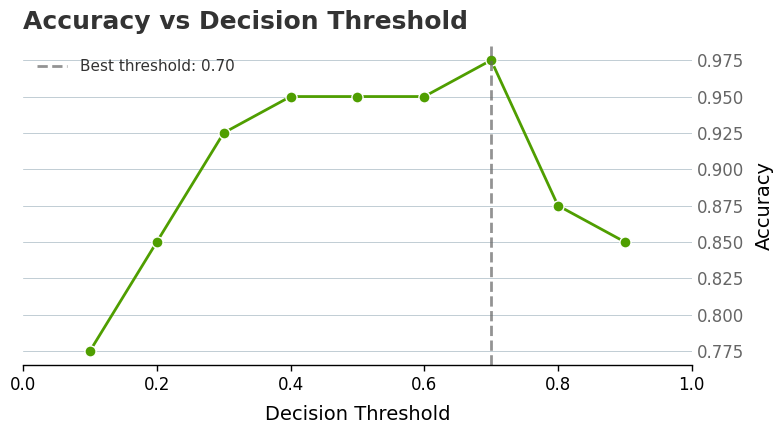

In [23]:
# Visualize threshold effect
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(thresholds, accuracies, 'o-', c=mt.GREEN, linewidth=2, markersize=8)

best_idx = np.argmax(accuracies)
ax.axvline(x=thresholds[best_idx], color=mt.GRAY, linestyle='--', alpha=0.7,
           label=f'Best threshold: {thresholds[best_idx]:.2f}')

ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Decision Threshold', fontweight='bold', loc='left')
ax.set_xlim(0, 1)
ax.legend()

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

---
## Summary

**Logistic Regression:**
- Models $P(y=1 \mid x)$ using the sigmoid function
- Hypothesis: $h(x) = \sigma(\boldsymbol{\theta}^T x) = \frac{1}{1 + e^{-\boldsymbol{\theta}^T x}}$
- Cost function: Log-loss (cross-entropy)
- Decision boundary: where $\boldsymbol{\theta}^T x = 0$

**Key differences from linear regression:**
- Output is a probability in $(0, 1)$
- Uses log-loss instead of MSE
- Same gradient descent algorithm, different hypothesis

**Next steps** (covered in the book):
- Regularization to prevent overfitting
- Multi-class classification
- Model evaluation metrics (precision, recall, ROC curves)